<a href="https://colab.research.google.com/github/MisterRus01/nlp/blob/main/NLP_LV3_bezrjesenja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LV3 - Klasifikacija teksta pomoću strojnog učenja



## Ciljevi laboratorijske vježbe:


*   Pripremiti označene skupove podataka za klasifikaciju teksta
*   Trenirati klasifikator
*   Evaluirati performanse klasifikatora (točnost, preciznost, odziv)



## 1. Instalacija biblioteka

In [1]:
from google.colab import files
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.svm import LinearSVC
import re
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline

## 2. Učitavanje dataseta Coronavirus tweets NLP - Text Classification

Potrebno je preuzeti javni dataset s platforme Kaggle. Kako bi preuzimanje bilo uspješno, potrebno je preuzeti datoteku `kaggle.json` sa svog Kaggle korisničkog profila i uploadati ju prilikom izvođenja sljedećeg programskog koda. Moguće je i preuzeti dataset i prenijeti ga u Google Colab ručno. Dataset možete preuzeti na [linku](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification).



In [2]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification

Saving Corona_NLP_test.csv to Corona_NLP_test.csv
Saving Corona_NLP_train.csv to Corona_NLP_train.csv
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [4]:
# Ovaj dataset dolazi kodiran u ISO-8859-1 (Latin-1), pa je potrebno specificirati encoding parametar
train = pd.read_csv("Corona_NLP_train.csv", encoding="latin1")
test = pd.read_csv("Corona_NLP_test.csv", encoding="latin1")

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## 3. Priprema podataka



### a) Odabir značajki

In [5]:
selected_features_train = train[['OriginalTweet', 'Sentiment']]
selected_features_test = test[['OriginalTweet', 'Sentiment']]

### b) Provjera nedostajućih vrijednosti

In [6]:
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_train.isnull().sum()}")

41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Budući da stupac Location neće biti korišten pri treniranju modela, nedostajuće vrijednosti se mogu zanemariti.

In [7]:
# ZADATAK: Provjerite nedostajuće vrijednosti u testnom skupu te riješite na prikladan način ukoliko ih ima
print(selected_features_train.shape[0])
print(f"Broj nedostajućih vrijednosti:\n{selected_features_test.isnull().sum()}")


41157
Broj nedostajućih vrijednosti:
OriginalTweet    0
Sentiment        0
dtype: int64


Broj ponavljanja svake kategorije tweetova (train skup):
Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


/tmp/ipython-input-2539597597.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=selected_features_train, palette='viridis')


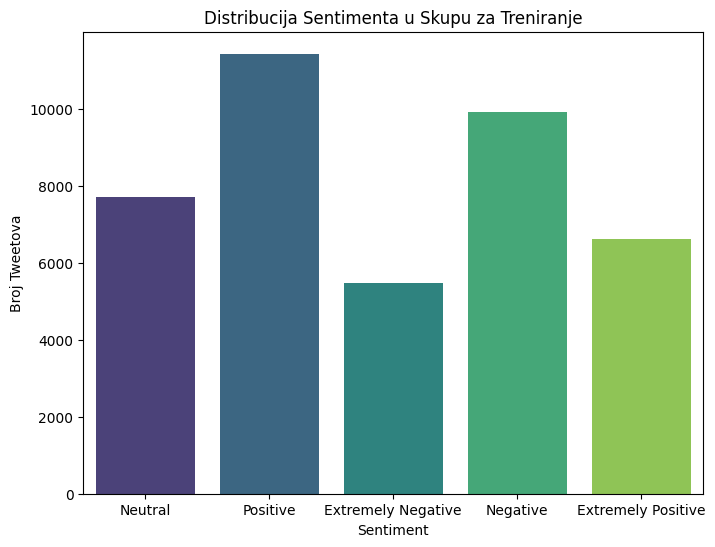

In [8]:
#ZADATAK: Provjerite broj ponavljanja svake od kategorija tweetova te ih prikžite na grafu koristeći prikladne biblioteke

sentiment_counts = selected_features_train['Sentiment'].value_counts()
print("Broj ponavljanja svake kategorije tweetova (train skup):")
print(sentiment_counts)

plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=selected_features_train, palette='viridis')
plt.title('Distribucija Sentimenta u Skupu za Treniranje')
plt.xlabel('Sentiment')
plt.ylabel('Broj Tweetova')
plt.show()


In [11]:
mapping = {
    'Positive': 'Positive',
    'Extremely Positive': 'Positive',
    'Negative': 'Negative',
    'Extremely Negative': 'Negative',
    'Neutral': 'Neutral'
}

selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)

#ZADATAK: Prikažite broj primjeraka u svakoj klasi nakon mapiranja

sentiment_counts = selected_features_train['Sentiment'].value_counts()
print("Broj ponavljanja svake kategorije tweetova (train skup):")
print(sentiment_counts)


Broj ponavljanja svake kategorije tweetova (train skup):
Sentiment
Positive    18046
Negative    15398
Neutral      7713
Name: count, dtype: int64


/tmp/ipython-input-4101431821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['Sentiment'] = selected_features_train['Sentiment'].map(mapping)
/tmp/ipython-input-4101431821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_test['Sentiment'] = selected_features_test['Sentiment'].map(mapping)


### c) Lematizacija i čišćenje teksta

In [12]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [14]:
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = word_tokenize(text)
    # lematizacija svake riječi
  lemmatized = [lemmatizer.lemmatize(token) for token in tokens]
    # vraćanje spojenog teksta
  return " ".join(lemmatized)
  pass
selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
selected_features_test['clean_tweet'] = selected_features_test['OriginalTweet'].apply(lemmatize_text).apply(clean_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
/tmp/ipython-input-1818056673.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_features_train['clean_tweet'] = selected_features_train['OriginalTweet'].apply(lemmatize_text).apply(clean_text)
/tmp/ipython-input-1818056673.py:19: SettingWithCopyWarning: 
A value is trying to be se

### d) Pretvaranje teksta u vektore značajki (TF-IDF)

TF-IDF (Term Frequency–Inverse Document Frequency) je statistička metoda koja se koristi u obradi prirodnog jezika i pretraživanju informacija za procjenu koliko je određena riječ važna za jedan dokument u odnosu na veću zbirku dokumenata. TF-IDF kombinira dvije komponente:
1. Frekvencija pojma (TF): Mjeri koliko se puta riječ pojavljuje u dokumentu. Veća učestalost sugerira veću važnost. Ako se neki pojam često pojavljuje u dokumentu, vjerojatno je relevantan za sadržaj tog dokumenta.
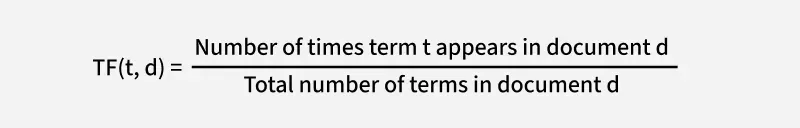

2. Obrnuta frekvencija dokumenta (IDF): Smanjuje težinu uobičajenih riječi koje se pojavljuju u više dokumenata, dok povećava težinu rijetkih riječi. Ako se pojam pojavljuje u manjem broju dokumenata, veća je vjerojatnost da je značajan i specifičan.
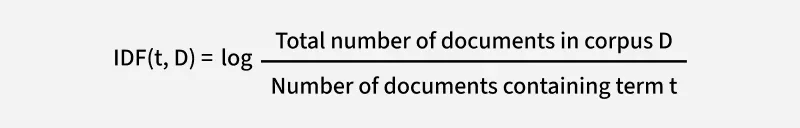

Ova ravnoteža omogućuje TF-IDF-u da istakne pojmove koji su i učestali unutar određenog dokumenta i prepoznatljivi u odnosu na ostatak zbirke dokumenata, što ga čini korisnim alatom za zadatke poput rangiranja pretraživanja, klasifikacije teksta i izdvajanja ključnih riječi.

In [15]:
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

X_train = tfidf.fit_transform(selected_features_train['clean_tweet'])

X_test = tfidf.transform(selected_features_test['clean_tweet'])

### e) Enkodiranje oznaka

In [16]:
le = LabelEncoder()

print(selected_features_train['Sentiment'].unique())

y_train = le.fit_transform(selected_features_train['Sentiment'])
y_test = le.transform(selected_features_test['Sentiment'])

y_train = pd.DataFrame(y_train, columns=['Sentiment'])
y_test = pd.DataFrame(y_test, columns=['Sentiment'])
y_train.head()

['Neutral' 'Positive' 'Negative']


,Sentiment
0,1
1,2
2,2
3,2
4,0


## 4. Treniranje modela - Naive Bayes

In [17]:
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(MultinomialNB(), param_grid, cv=skf, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Best alpha: {'alpha': 0.1}
Best cross-val accuracy: 0.6790584824797198


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [18]:
model = MultinomialNB(alpha = 0.1)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=0.1)

## 5. Evaluacija performansi

In [19]:
y_pred = model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

              precision    recall  f1-score   support

    Negative       0.72      0.73      0.72      1633
     Neutral       0.64      0.21      0.31       619
    Positive       0.64      0.81      0.71      1546

    accuracy                           0.68      3798
   macro avg       0.67      0.58      0.58      3798
weighted avg       0.68      0.68      0.65      3798

Confusion Matrix:

[[1185   48  400]
 [ 185  129  305]
 [ 268   26 1252]]


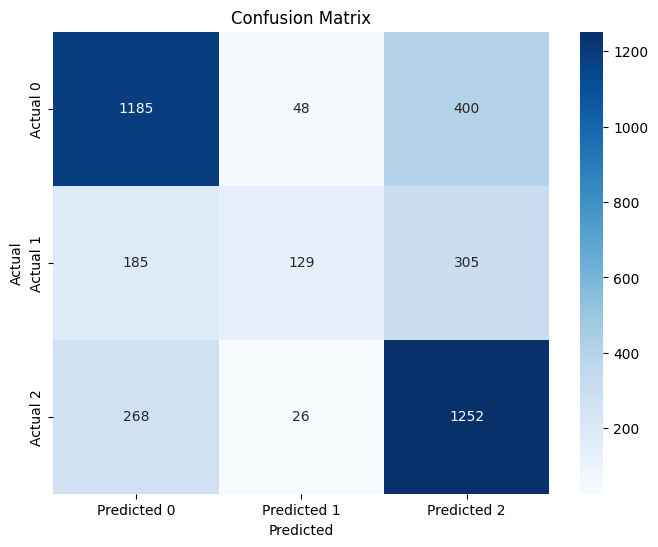

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

## ZADATAK:
Trenirati model koristeći SVM i usporediti performanse s Naive Bayes-om.

In [22]:
svm = LinearSVC()
svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

print("SVM Results:")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print("F1 Score:", f1_score(y_test, svm_pred, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, svm_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Results:
Accuracy: 0.7864665613480779
F1 Score: 0.785682612354007

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1633
           1       0.68      0.64      0.66       619
           2       0.80      0.84      0.82      1546

    accuracy                           0.79      3798
   macro avg       0.76      0.76      0.76      3798
weighted avg       0.79      0.79      0.79      3798



# Zadatak – samostalan rad na datasetu

### U ovom zadatku studenti će sami proći cijeli proces klasifikacije teksta koristeći metode strojnog učenja – od pripreme podataka do treniranja i usporedbe različitih modela.

Cilj je klasificirati opise proizvoda iz e-trgovine u jednu od četiri kategorije (Electronics, Household, Books, Clothing & Accessories).

### Koraci zadatka:

1. **Pregled dataseta**  
   - Preuzmite dataset „E-commerce Text Classification“ s Kaggle-a:  
     https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification  
   - Učitajte ga u Colab (npr. pomoću `pd.read_csv`)  
   - Prikažite osnovne informacije o datasetu

2. **Odabir značajki i čišćenje podataka**  
   - Provjerite i obradite nedostajuće vrijednosti
   - Uklonite duplikate ako postoje  
   - Po potrebi uravnotežite dataset (npr. undersampling/oversampling) – nije obavezno, ali je plus

3. **Predobrada teksta (čišćenje i lematizacija)**  
   - Pretvorite tekst u mala slova  
   - Uklonite HTML tagove, URL-ove, interpunkciju, brojeve, specijalne znakove  
   - Uklonite stop-riječi  
   - Provedite lematizaciju

4. **Pretvaranje teksta u vektore značajki**  
     - `TfidfVectorizer`
   - Podijelite podatke na train/test skup (80/20 ili 75/25)

5. **Enkodiranje oznaka (labela)**  
   - Pretvorite tekstualne kategorije u brojčane pomoću `LabelEncoder` ili `OneHotEncoder` (ovisno o modelu)

6. **Treniranje i usporedba modela**  
   
   
   Za svaki model:
   - Naučite model na trening skupu
   - Izmjerite performanse na test skupu: **accuracy, precision, recall, F1-score**
   - Nacrtajte **confusion matrix** i **classification report**
   - Ako stignete: Podesite hiperparametre (barem `GridSearchCV` ili `RandomizedSearchCV` na 2–3 parametra) za bolje rezultate

7. **Vizualizacija rezultata**  
   - Usporedite dva (ili više) modela u tablici i stupčastim grafom (accuracy, F1-score)
   
   - Ako koristite TF-IDF, pokažite 10–20 riječi s najvećim TF-IDF težinama po klasi (Iz riječi biste trebali zaključiti o kojoj klasi se radi)

8. **Zaključak i komentar rezultata**  
   - Koji model je bio bolji i zašto?
   - Koje su prednosti i nedostaci pristupa koje ste koristili?
   - Što biste još mogli isprobati da poboljšate rezultat (ideje za daljnje eksperimente)?
   - Koliko je predobrada teksta utjecala na performanse?


In [27]:
cols = ['Label', 'Description']
df=pd.read_csv('ecommerceDataset.csv',names=cols, engine='python')
df.head()

,Label,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [28]:
df.shape

(50425, 2)

In [29]:
df.columns

Index(['Label', 'Description'], dtype='object')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Label        50425 non-null  object
 1   Description  50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [32]:
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

Label          0
Description    0
dtype: int64
Label          0
Description    0
dtype: int64


In [33]:
df.drop_duplicates(inplace=True)

In [36]:
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_and_lemmatize(text):
    text = text.lower()

    text = BeautifulSoup(text, "lxml").get_text()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)

    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word not in stop_words]

    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)

In [38]:
df['clean_text'] = df['Description'].apply(clean_and_lemmatize)
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['clean_text'])

In [39]:
le = LabelEncoder()
y = le.fit_transform(df['Label'])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

print("Veličina trening skupa:", X_train.shape)
print("Veličina testnog skupa:", X_test.shape)

Veličina trening skupa: (22241, 5000)
Veličina testnog skupa: (5561, 5000)


In [41]:
df.head()

,Label,Description,clean_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood inch x inch sp...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv textured modern art print framed painti...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic inc...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gift india wooden happy birthday un...


In [43]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

 Naive Bayes 
Accuracy: 0.932745909009171
Precision: 0.9337660990909155
Recall: 0.932745909009171
F1-score: 0.93262168006758

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.93      1251
           1       0.95      0.97      0.96      1135
           2       0.92      0.91      0.91      1062
           3       0.91      0.95      0.93      2113

    accuracy                           0.93      5561
   macro avg       0.94      0.93      0.93      5561
weighted avg       0.93      0.93      0.93      5561



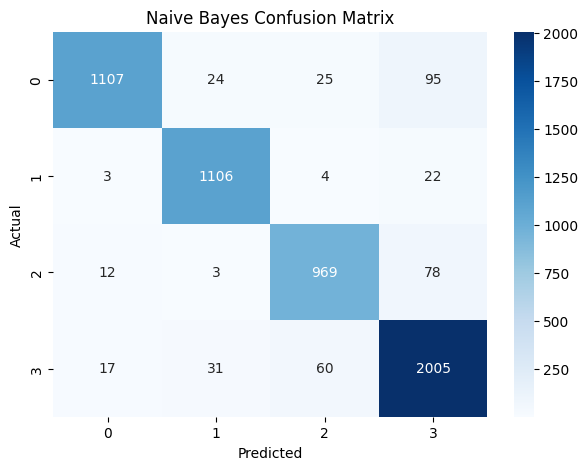

In [44]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print(" Naive Bayes ")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_nb, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")

 SVM 
Accuracy: 0.9523467002337709
Precision: 0.9523180936554495
Recall: 0.9523467002337709
F1-score: 0.9522931311934715

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      1251
           1       0.97      0.98      0.97      1135
           2       0.94      0.93      0.93      1062
           3       0.95      0.96      0.95      2113

    accuracy                           0.95      5561
   macro avg       0.95      0.95      0.95      5561
weighted avg       0.95      0.95      0.95      5561



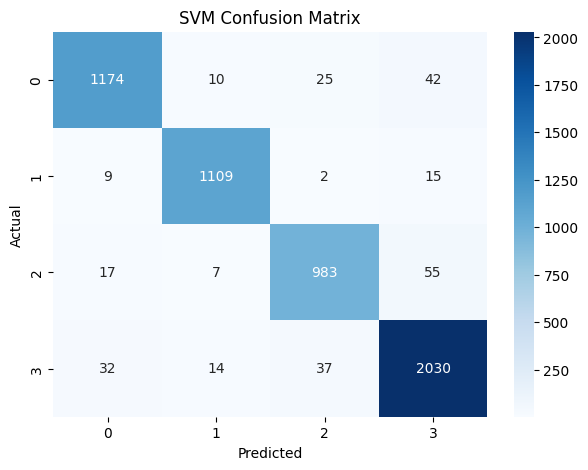

In [45]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print(" SVM ")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_svm, average='weighted'))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

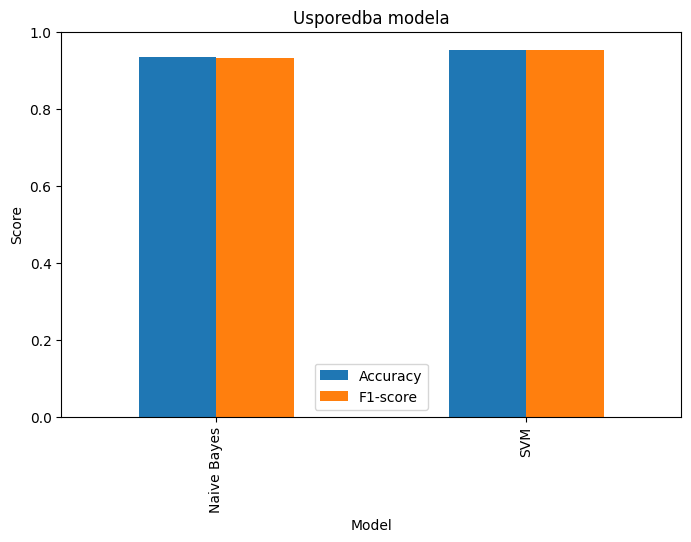

In [48]:
model_names = ['Naive Bayes', 'SVM']
accuracy_scores = [accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_svm)]
f1_scores = [f1_score(y_test, y_pred_nb, average='weighted'), f1_score(y_test, y_pred_svm, average='weighted')]

results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracy_scores,
    'F1-score': f1_scores
})

results_df.plot(x='Model', y=['Accuracy','F1-score'], kind='bar', figsize=(8,5))
plt.title("Usporedba modela")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

In [49]:
import numpy as np
X_tfidf_array = X_train.toarray()
feature_names = np.array(tfidf.get_feature_names_out())

for class_idx, class_name in enumerate(le.classes_):
    class_docs_idx = np.where(y_train == class_idx)[0]

    class_tfidf_mean = X_tfidf_array[class_docs_idx].mean(axis=0)

    top_n = 15
    top_indices = class_tfidf_mean.argsort()[::-1][:top_n]
    top_words = feature_names[top_indices]

    print(f"Top {top_n} riječi za klasu '{class_name}':")
    print(top_words)
    print("\n")

Top 15 riječi za klasu 'Books':
['book' 'author' 'review' 'university' 'student' 'new' 'life' 'world'
 'story' 'exam' 'india' 'year' 'science' 'guide' 'paper']


Top 15 riječi za klasu 'Clothing & Accessories':
['cotton' 'men' 'womens' 'wear' 'girl' 'fit' 'fabric' 'boy' 'look' 'woman'
 'size' 'pack' 'soft' 'comfort' 'sock']


Top 15 riječi za klasu 'Electronics':
['camera' 'usb' 'cable' 'speaker' 'mm' 'black' 'gb' 'bluetooth' 'phone'
 'device' 'laptop' 'card' 'audio' 'wireless' 'lens']


Top 15 riječi za klasu 'Household':
['set' 'steel' 'home' 'product' 'cm' 'stainless' 'table' 'color' 'easy'
 'use' 'kitchen' 'water' 'quality' 'design' 'inch']


